In [1]:
import matplotlib.pyplot as plt
import TransportMaps as TM
import TransportMaps.Distributions as DIST
import TransportMaps.Diagnostics as DIAG
%matplotlib inline

# XML transport map descriptors

As it is shown in the examples of the tutorial, the construction of transport maps require two steps

1. the definition of the parametric family (**structure**) of the transport map
2. the minimization of a cost function (often the KL-divergence)

The first step can be cumbersome, when one needs to define every detail of the transport map (basis types, order, sparsity pattern, monotonic type, triangular map type etc.). Therefore, we provide a faster way to define the **structure** of a transport map through an [XML](https://en.wikipedia.org/wiki/XML) file ([XML tutorial](https://www.w3schools.com/xml/)).

XML is a *markup language* that allows to encode documents in a human readable structured format.
Even if very complex maps with a very involved sparsity structure would be difficult to encode in this language, it allows nevertheless the definition of a broad set of map structures which are often chosen for the solution of real problems.

We will go through some increasingly involved examples and then provide a full problem worked out. 

More *XML examples* files can be found in the unittest folder ``TransportMaps/tests/xml/maps``. The full **syntax** is described in the [XML Schema Definition (XSD)](https://en.wikipedia.org/wiki/XML_schema) ([XSD tutorial](https://www.w3schools.com/xml/schema_intro.asp)) file ``TransportMaps/XML/schema/map.xsd`` and ``TransportMaps/XML/schema/basis.xsd`` (the latter is a link to the corresponding file in the [SpectralToolbox](https://launchpad.net/spectraltoolbox) package).

All the XML functionalities are collected in the following module:

In [2]:
import TransportMaps.XML as TMXML

## Map structure examples

### Linear span map with linear components

Here we define the transport map with structure:

$$ T({\bf x}) = \left[ \begin{array}{l} 
T_1(x_1) \\
T_2(x_1, x_2) \\ 
\qquad \vdots \\
T_d(x_1,\ldots,x_d)
\end{array} \right] = \left[ \begin{array}{c}
a_1 \\ a_2 \\ \vdots \\ a_d
\end{array} \right] + \left[ \begin{array}{cccc}
b_{1,1} & & &\\
b_{2,1} & b_{2,2} & &\\
\vdots & & \ddots & \\
b_{d,1} & \cdots & \cdots & b_{d,d}
\end{array} \right] {\bf x} \;.$$

Each component $T_i$ is then a [LinearSpanApproximation](api-TransportMaps-Functionals.html#TransportMaps.Functionals.LinearSpanApproximation):

$$ T_i({\bf x}) = a_i + b_{i,1} \,x_1 + \ldots + b_{i,i} \, x_i \;. $$

The following XML code describe such a structure.

    <?xml version="1.0"?>
    <trimap xmlns="TransportMaps" xmlns:st="SpectralToolbox"
        xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
        xsi:schemaLocation="map.xsd" type="linspan" dim="5">
      <component id="*">
        <avars>
          <vars>*</vars>
        </avars>
        <approx>
          <linspan multidimtype="tensorized" spantype="total">
            <spanorder>
              <maxord coord="*">1</maxord>
            </spanorder>
            <spanbasis coord="*">
              <st:HermiteProbabilistsPolynomial/>
            </spanbasis>
          </linspan>
        </approx>
      </component>
    </trimap>

This descriptor can be stored in a file (``aux/xml/LinearSpan.xml``) and used to instantiate the corresponding object.

In [3]:
T = TMXML.load_xml('aux/xml/LinearSpan.xml')
type(T)

TransportMaps.Maps.TriangularTransportMaps.LinearSpanTriangularTransportMap

Let us walk through the XML file line-by-line to explain its syntax.

    <trimap 
        xmlns="TransportMaps"
        xmlns:st="SpectralToolbox"
        xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
        xsi:schemaLocation="map.xsd"
        type="linspan" dim="5">
    ...
    </trimap>

This block contains all the transport map descriptor. The tag ``trimap`` stands for triangular map. Therefore we are defining a triangular map $T$ of type linear span (``linspan``) and dimension (``dim``) 5. The attributes ``xmlns="TransportMaps"`` and ``xmlns:st="SpectralToolbox"`` are used only to define the appropriate namespaces.

      <component id="*">
      ...
      </component>

The ``component`` block identifies a component $T_i$ of the map. In this case the ``id="*"`` indicates that we are defining all the components $T_1,\ldots,T_5$ at once, since they will all have similar structure (i.e. all linear, but preserving the lower triangular structure of $T$).

        <avars>
          <vars>*</vars>
        </avars>
        
The ``avars`` block defines the list of active variable for the ``component`` at hand. In this case the map will be full lower triangular, so each component $T_i$ will depend on all the variables $x_1,\ldots,x_i$. The entry ``<vars>*</vars>`` specifies this structure.

        <approx>
          <linspan multidimtype="tensorized" spantype="total">
          ...
          </linspan>
        </approx>

The ``approx`` field specify the form of $T_i$. In this case it will be a [LinearSpanApproximation](api-TransportMaps-Functionals.html#TransportMaps.Functionals.LinearSpanApproximation) (``linspan``), where the basis are obtained from tensorization of 1-d basis (``multidimtype="tensorized"``) and we will chose a total order expansion (``spantype="total"``), in order to get a linear map in the end.

            <spanorder>
              <maxord coord="*">1</maxord>
            </spanorder>

The filed ``spanorder`` defines the total (polynomial) order of the expansion. The approximation can be anisotropic, allowing for different orders to be defined for different directions (in this case $T_i$ will depend on $i$ variables, i.e. $i$ directions). In this case the approximation is isotropic and linear, so ``<maxord coord="*">1</maxord>`` impose linearity (``1``) for every direction (``coord="*"``).

            <spanbasis coord="*">
              <st:HermiteProbabilistsPolynomial/>
            </spanbasis>

The field ``spanbasis`` defined the basis type to be used for the approximation. Here we use [Hermite probabilists' polynomials](http://pythonhosted.org//SpectralToolbox/api-spectral1d.html#SpectralToolbox.Spectral1D.HermiteProbabilistsPolynomial) from the package [SpectralToolbox](https://pypi.python.org/pypi/SpectralToolbox) for every direction (``coord="*"``).

### Integrated squared second order map

Here we define a full lower triangular map where every component is an [integrated squared approximation](api-TransportMaps-Functionals.html#TransportMaps.Functionals.MonotonicIntegratedSquaredApproximation) (see [example](example-gumbel-1d.html#Integrated-squared-parametrization)):

$$ T_k({\bf a};{\bf x}) = c({\bf a}_c;{\bf x}) + \int_0^{x_k} \left( h\left({\bf a}_e;x_1,\ldots,x_{k-1},t \right) \right)^2 \, dt \;,$$

where $c$ and $h$ are themselves two parametric [LinearSpanApproximation](api-TransportMaps-Functionals.html#TransportMaps.Functionals.LinearSpanApproximation):

$$ c({\bf a}_c,{\bf x}) = \Phi_c({\bf x}) {\bf a}_c \quad \text{and} \quad h({\bf a}_e,{\bf x}) = \Phi_e(x_1,\ldots,x_{k-1},t) {\bf a}_e \;.$$

XML descriptor...

    <?xml version="1.0"?>
    <trimap xmlns="TransportMaps" xmlns:st="SpectralToolbox"
        xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
        xsi:schemaLocation="map.xsd" type="intsq" dim="5">
      <component id="*">
        <avars>
          <vars>*</vars>
        </avars>
        <approx>
          <intsq>
            <constant>
              <linspan multidimtype="tensorized" spantype="full">
                <spanorder>
                  <maxord coord=":d">2</maxord>
                  <maxord coord="d">0</maxord>
                </spanorder>
                <spanbasis coord="*">
                  <st:HermiteProbabilistsPolynomial/>
                </spanbasis>
              </linspan>
            </constant>
            <squared>
              <linspan multidimtype="tensorized" spantype="total">
                <spanorder>
                  <maxord coord=":d">2</maxord>
                  <maxord coord="d">1</maxord>
                </spanorder>
                <spanbasis coord="*">
                  <st:ConstantExtendedHermiteProbabilistsFunction/>
                </spanbasis>
              </linspan>
            </squared>
          </intsq>
        </approx>
      </component>
    </trimap>

This descriptor can be store in a file (``aux/xml/IntSqSecOrd.xml``) and used to instantiate the corresponding object.

In [4]:
T = TMXML.load_xml('aux/xml/IntSqSecOrd.xml')
type(T)

TransportMaps.Maps.TriangularTransportMaps.IntegratedSquaredTriangularTransportMap

The descriptor has many things in common with our previous example, therefore we will only focus on their main differences.

1. The ``trimap`` is now of type ``intsq`` ([IntegratedSquaredTriangularTransportMap](api-TransportMaps-Maps.html#TransportMaps.Maps.IntegratedSquaredTriangularTransportMap)).
2. The block ``approx`` (for each $T_i$) contains now a ``intsq`` sub-block rather than a ``linspan`` one.
3. The ``intsq`` block is formed by two parts, ``constant`` and ``squared``, which contain the descriptors for the individual [LinearSpanApproximation](api-TransportMaps-Functionals.html#TransportMaps.Functionals.LinearSpanApproximation) approximations.
4. The basis ``ConstantExtendedHermiteProbabilistsFunction`` is used for the ``squared`` part of the approximation (for theoretical reasons beyond the scope of this tutorial)
5. The ``maxord`` of the ``squared`` part is only 1 in the $d$ direction (which is the direction $i$ for component $T_i$). This is done because the integrated squared format will provide for the extra order thanks to the integral along direction $d$.

### Second order head map + second order tail

The following map is more anisotropic that the preceding two. It will be defined as follows:

1. $T_1,\ldots,T_3$ are second order integrated squared approximations depending on all the variables
2. $T_{i>3}$ are second order integrated squared approximations depending only on the $i$-th variable

The sparsity structure of the map can be graphically represented as follows:

$$ \left[ \begin{array}{cccccc}
x &   &   &   &   & \\
x & x &   &   &   & \\
x & x & x &   &   & \\
  &   &   & x &   & \\
  &   &   &   & \ddots & \\
  &   &   &   &   & x 
  \end{array} \right] $$

The following code defines such a map.

    <?xml version="1.0"?>
    <trimap xmlns="TransportMaps" xmlns:st="SpectralToolbox"
        xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
        xsi:schemaLocation="map.xsd" type="intsq" dim="5">
      <component id=":3">
        <avars>
          <vars>*</vars>
        </avars>
        <approx>
          <intsq>
            <constant>
              <linspan multidimtype="tensorized" spantype="total">
                <spanorder>
                  <maxord coord=":d">2</maxord>
                  <maxord coord="d">0</maxord>
                </spanorder>
                <spanbasis coord="*">
                  <st:HermiteProbabilistsPolynomial/>
                </spanbasis>
              </linspan>
            </constant>
            <squared>
              <linspan multidimtype="tensorized" spantype="total">
                <spanorder>
                  <maxord coord=":d">2</maxord>
                  <maxord coord="d">1</maxord>
                </spanorder>
                <spanbasis coord="*">
                  <st:ConstantExtendedHermiteProbabilistsFunction/>
                </spanbasis>
              </linspan>
            </squared>
          </intsq>
        </approx>
      </component>
      <component id="3:">
        <avars>
          <vars>d</vars>
        </avars>
        <approx>
          <intsq>
            <constant>
              <linspan multidimtype="tensorized" spantype="total">
                <spanorder>
                  <maxord coord="*">0</maxord>
                </spanorder>
                <spanbasis coord="*">
                  <st:HermiteProbabilistsPolynomial/>
                </spanbasis>
              </linspan>
            </constant>
            <squared>
              <linspan multidimtype="tensorized" spantype="total">
                <spanorder>
                  <maxord coord="*">1</maxord>
                </spanorder>
                <spanbasis coord="*">
                  <st:ConstantExtendedHermiteProbabilistsFunction/>
                </spanbasis>
              </linspan>
            </squared>
          </intsq>
        </approx>
      </component>
    </trimap>

This descriptor can be store in a file (aux/xml/IntSqSecOrdHead.xml) and used to instantiate the corresponding object.

In [5]:
T = TMXML.load_xml('aux/xml/IntSqSecOrdHead.xml')
type(T)

TransportMaps.Maps.TriangularTransportMaps.IntegratedSquaredTriangularTransportMap

The main differences with the preceding example are the following:

1. The ``trimap`` now contains two ``component`` blocks; the first one takes care of the description of the head of the map, while the second one takes care of the tail of the map (diagonal part).
2. The attributes ``id=":3"`` and ``id="3:"`` are used to identify the two parts of the map and define multiple components at a time (syntax equivalent to the python slicing)
3. The exclusive dependency on $x_i$ of each component $T_{i>3}$ is enforced by the active variable ``<vars>d</vars>`` appearing in the block ``avars``.

## The BOD model revisited

We revisit the BOD problem, but now we employ a more **anisotropic map**, which stems from our belief that a subgroup of variables are interacting in a stronger way than other. We do so prescribing a particular map structure throguh an XML file.

The BOD example was already treated [here](example-BOD-4d.html).

Let us first load the target distribution $\nu_\pi$.

In [6]:
import TransportMaps.Distributions.Examples.BiochemicalOxigenDemand as BOD
pi = BOD.BODjoint(2)

We then define an integrated squared triangular map, with total order 3, but for the **interacting terms between the last 2 dimensions**, for which we use a total order 4:

    <?xml version="1.0"?>
    <trimap xmlns="TransportMaps" xmlns:st="SpectralToolbox"
    xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
    xsi:schemaLocation="map.xsd" type="intsq" dim="4">
      <component id=":2">
        <avars>
          <vars>*</vars>
        </avars>
        <approx>
          <intsq>
            <constant>
              <linspan multidimtype="tensorized" spantype="total">
                <spanorder>
                  <maxord coord=":d">3</maxord>
                  <maxord coord="d">0</maxord>
                </spanorder>
                <spanbasis coord="*">
                  <st:HermiteProbabilistsPolynomial/>
                </spanbasis>
              </linspan>
            </constant>
            <squared>
              <linspan multidimtype="tensorized" spantype="total">
                <spanorder>
                  <maxord coord=":d">3</maxord>
                  <maxord coord="d">2</maxord>
                </spanorder>
                <spanbasis coord="*">
                  <st:ConstantExtendedHermiteProbabilistsFunction/>
                </spanbasis>
              </linspan>
            </squared>
          </intsq>
        </approx>
      </component>
      <component id="2:">
        <avars>
          <vars>*</vars>
        </avars>
        <approx>
          <intsq>
            <constant>
              <linspan multidimtype="tensorized" spantype="total">
                <spanorder>
                  <maxord coord=":2">3</maxord>
                  <maxord coord="2:d">4</maxord>
                  <maxord coord="d">0</maxord>
                </spanorder>
                <spanbasis coord="*">
                  <st:HermiteProbabilistsPolynomial/>
                </spanbasis>
              </linspan>
            </constant>
            <squared>
              <linspan multidimtype="tensorized" spantype="total">
                <spanorder>
                  <maxord coord=":2">3</maxord>
                  <maxord coord="2:d">4</maxord>
                  <maxord coord="d">3</maxord>
                </spanorder>
                <spanbasis coord="*">
                  <st:ConstantExtendedHermiteProbabilistsFunction/>
                </spanbasis>
              </linspan>
            </squared>
          </intsq>
        </approx>
      </component>
    </trimap>

The file ``aux/xml/BODmap.xml`` encodes this information.

In [7]:
T = TMXML.load_xml('aux/xml/BODmap.xml')
print("Number of coefficients: %d" % T.get_n_coeffs())

Number of coefficients: 147


Let us solve the usual variational problem to obtain $T_{\sharp}\nu_\rho \approx \nu_\pi$ ...

In [8]:
dim = pi.dim
rho = DIST.StandardNormalDistribution( dim )
push_rho = DIST.PushForwardTransportMapDistribution(T, rho)
# SOLVE
qtype = 3              # Gauss quadrature
qparams = [7]*dim      # Quadrature order
reg = {'type': 'L2',
       'alpha': 1e-2}  # L2 regularization
tol = 1e-3             # Optimization tolerance
ders = 2               # Use gradient and Hessian
log = push_rho.minimize_kl_divergence(
    pi, qtype=qtype, qparams=qparams, regularization=reg,
    tol=tol, ders=ders)

Optimization terminated successfully.
         Current function value: 9.244728
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 36
         Hessian evaluations: 291


... let's check the accuracy of the approximation using the variance diagnostic ...

In [9]:
pull_pi = DIST.PullBackTransportMapDistribution(T, pi)
qtype = 0        # Monte-Carlo quadrature
qparams = 100000 # Number of samples
var_diag = DIAG.variance_approx_kl(rho, pull_pi, qtype=qtype, qparams=qparams)
print("Variance diagnostic: %e" % var_diag)

Variance diagnostic: 8.408883e-02


... let's check the pullback conditionals ...

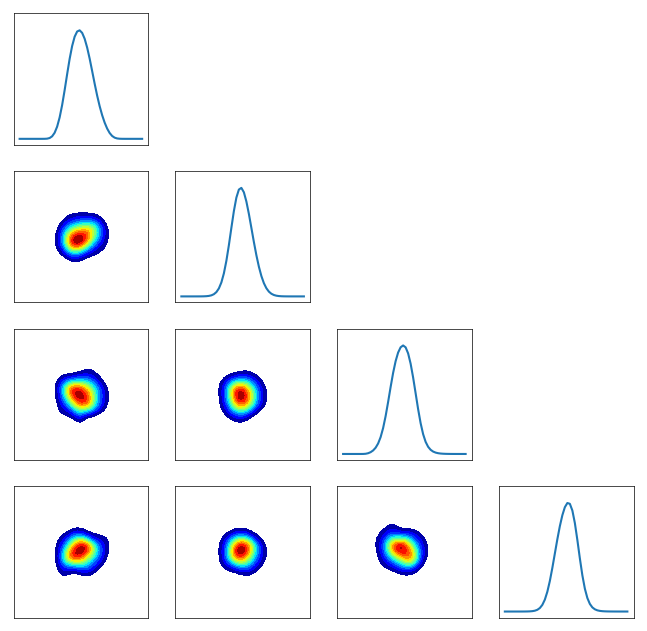

In [10]:
pull_pi = DIST.PullBackTransportMapDistribution(T, pi)
fig = DIAG.plotAlignedConditionals(pull_pi, range_vec=[-6,6], numPointsXax=50, show_flag=False)